## Intrinsic parameter for a single camera
Output: intrinsic matrix K and distortion coefficients D

From the manufacturer's datasheet:
- focal lenghts fx, fy
- principal point (cx, cy)
- D = distortion coefficients (k1, k2, p1, p2, k3)

From this pipeline:
- K = intrinsic matrix 

In [11]:
if '/Users/damianstone/Documents/Code/tennis-project/post-triangulation/' not in sys.path:
  sys.path.append('/Users/damianstone/Documents/Code/tennis-project/post-triangulation/')

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import glob
import sys
import json

from utils.utils import print_image

  
BASE_PATH = '/Users/damianstone/Documents/Code/tennis-project/post-triangulation/'

# two stereo pairs each side of the court
CAMERAS = ['CAM_1_LEFT', 'CAM_2_RIGHT', 'CAM_3_LEFT', 'CAM_4_RIGHT']

# output file name where we store the intrinsic parameters for each camera
OUT_PARAMS_FILE_NAME = f'{BASE_PATH}/data/intrinsic_params.json'


### Using manufacturer data

In [12]:
with open(OUT_PARAMS_FILE_NAME, "r") as file:
    camera_data = json.load(file)

# update each camera entry with the intrinsic matrix K
for cam, params in camera_data.items():
    fx, fy, cx, cy = params["fx"], params["fy"], params["cx"], params["cy"]
    K = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
    params["K"] = K

with open(OUT_PARAMS_FILE_NAME, "w") as file:
    json.dump(camera_data, file, indent=4)

print(f"Updated JSON saved to {OUT_PARAMS_FILE_NAME}")

Updated JSON saved to /Users/damianstone/Documents/Code/tennis-project/post-triangulation//data/intrinsic_params.json


In [13]:
camera_data

{'CAM_1_LEFT': {'fx': 1800.0,
  'fy': 1805.0,
  'cx': 1920.0,
  'cy': 1080.0,
  'D': [-0.25, 0.05, 0.0, 0.0, -0.02],
  'K': [[1800.0, 0, 1920.0], [0, 1805.0, 1080.0], [0, 0, 1]]},
 'CAM_2_RIGHT': {'fx': 1795.0,
  'fy': 1800.0,
  'cx': 1918.0,
  'cy': 1078.0,
  'D': [-0.23, 0.04, 0.0, 0.0, -0.015],
  'K': [[1795.0, 0, 1918.0], [0, 1800.0, 1078.0], [0, 0, 1]]},
 'CAM_3_LEFT': {'fx': 1810.0,
  'fy': 1812.0,
  'cx': 1925.0,
  'cy': 1082.0,
  'D': [-0.27, 0.06, 0.0, 0.0, -0.018],
  'K': [[1810.0, 0, 1925.0], [0, 1812.0, 1082.0], [0, 0, 1]]},
 'CAM_4_RIGHT': {'fx': 1805.0,
  'fy': 1810.0,
  'cx': 1922.0,
  'cy': 1081.0,
  'D': [-0.24, 0.05, 0.0, 0.0, -0.017],
  'K': [[1805.0, 0, 1922.0], [0, 1810.0, 1081.0], [0, 0, 1]]}}

### Using a chessboard

LEFT


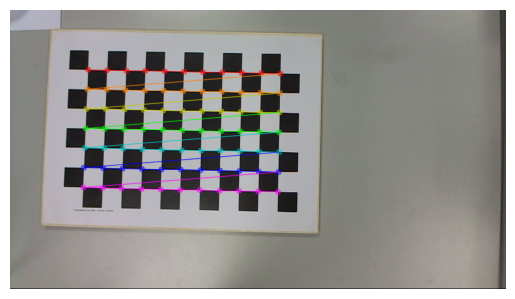

LEFT


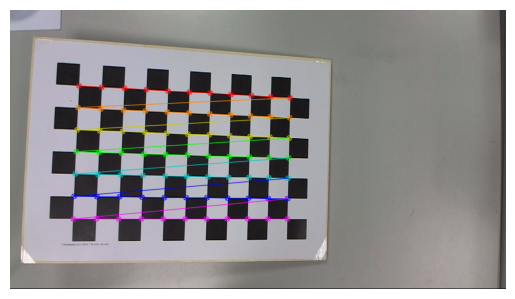

LEFT


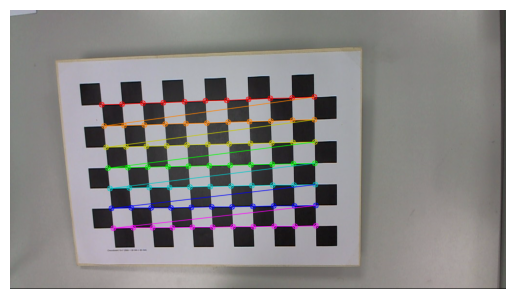

{'CAM_1_LEFT': {'fx': 1800.0, 'fy': 1805.0, 'cx': 1920.0, 'cy': 1080.0, 'D': [[0.031065466847288115, -0.17971041918286587, 0.0008742454765841088, 0.00017705165552900554, 0.2137290565159718]], 'K': [[717.1041190793976, 0.0, 523.8087440893095], [0.0, 727.6917880416373, 286.17021970497035], [0.0, 0.0, 1.0]], 'ROI': (4, 2, 1016, 570)}, 'CAM_2_RIGHT': {'fx': 1795.0, 'fy': 1800.0, 'cx': 1918.0, 'cy': 1078.0, 'D': [-0.23, 0.04, 0.0, 0.0, -0.015], 'K': [[1795.0, 0, 1918.0], [0, 1800.0, 1078.0], [0, 0, 1]]}, 'CAM_3_LEFT': {'fx': 1810.0, 'fy': 1812.0, 'cx': 1925.0, 'cy': 1082.0, 'D': [-0.27, 0.06, 0.0, 0.0, -0.018], 'K': [[1810.0, 0, 1925.0], [0, 1812.0, 1082.0], [0, 0, 1]]}, 'CAM_4_RIGHT': {'fx': 1805.0, 'fy': 1810.0, 'cx': 1922.0, 'cy': 1081.0, 'D': [-0.24, 0.05, 0.0, 0.0, -0.017], 'K': [[1805.0, 0, 1922.0], [0, 1810.0, 1081.0], [0, 0, 1]]}}


In [ ]:
from utils.utils import get_frame_size

IMG_BASE_PATH = f'{BASE_PATH}/images/gopros'
CHESSBOARD_SIZE = (11, 7) # rows, columnss
SQUARE_SIZE_MM = 30 
FRAME_SIZE = get_frame_size(f'{IMG_BASE_PATH}/{CAMERAS[0]}/*.png')
IMAGES = glob.glob(f'{IMG_BASE_PATH}/{CAMERAS[0]}/*.png')

# how exact we want to be find the corners of each square in the chessboard 
# 30 = max number of iterations
# 0.001 = stop if the change in the corner position is less than 0.001 - convergence threshold 
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# create 3D points of the chessboard corners
# each row represents a coordinate of a corner of the chessboard
# corner = interesection between two squares
objp = np.zeros(
  (CHESSBOARD_SIZE[0] * CHESSBOARD_SIZE[1], 3), 
  np.float32
)

# it generates a grid of (x, y) coordinates for chessboard corners and stores them as 3D points with z = 0 for calibration
# z = 0 because the chessboard is flat
objp[:,:2] = np.mgrid[
  0:CHESSBOARD_SIZE[0],
  0:CHESSBOARD_SIZE[1]
  ].T.reshape(-1,2)

objp = objp * SQUARE_SIZE_MM

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane

i = 0
for cam_img in IMAGES:
  img = cv.imread(cam_img)
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  # find the chessboard corners
  ret, corners = cv.findChessboardCorners(gray, CHESSBOARD_SIZE, None)

  # if corners are found, add object points, image points (after refining them)
  if ret:
    # store the same object for each image
    objpoints.append(objp)

    # get all the coordinates of the corners
    corners = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    
    # append the corners to the imgpoints list
    imgpoints.append(corners)

    if i < 3:
      #draw and display the corners
      cv.drawChessboardCorners(img, CHESSBOARD_SIZE, corners, ret)
      print("LEFT")
      print_image(img)
      i += 1
    cv.waitKey(1000)

cv.destroyAllWindows()


# intrinsic parameters
# ret = reprojection error
# K = intrinsic matrix
# D = distortion coefficients -> how much the lens bends the image (q tanto curva la imagen el lente)
# R = rotation vectors
# T = translation vectors
ret, K, D, R, T = cv.calibrateCamera(objpoints, imgpoints, FRAME_SIZE, None, None)
height, width, channels = img.shape

# adjust cameras matrix to reduce distortion
NEW_K, roi = cv.getOptimalNewCameraMatrix(
                              K, 
                              D, 
                              (width, height), 
                              1, 
                              (width, height)
                          )


# save the intrinsic parameters
camera_data[CAMERAS[0]]["D"] = D.tolist()
camera_data[CAMERAS[0]]["K"] = NEW_K.tolist()
# roi (Region of Interest) defines the valid pixel region after undistortion
# It returns (x, y, w, h) that can be used to crop the undistorted image
# This helps remove any black borders created during the undistortion process
camera_data[CAMERAS[0]]["ROI"] = roi



In [15]:
camera_data

{'CAM_1_LEFT': {'fx': 1800.0,
  'fy': 1805.0,
  'cx': 1920.0,
  'cy': 1080.0,
  'D': [[0.031065466847288115,
    -0.17971041918286587,
    0.0008742454765841088,
    0.00017705165552900554,
    0.2137290565159718]],
  'K': [[717.1041190793976, 0.0, 523.8087440893095],
   [0.0, 727.6917880416373, 286.17021970497035],
   [0.0, 0.0, 1.0]],
  'ROI': (4, 2, 1016, 570)},
 'CAM_2_RIGHT': {'fx': 1795.0,
  'fy': 1800.0,
  'cx': 1918.0,
  'cy': 1078.0,
  'D': [-0.23, 0.04, 0.0, 0.0, -0.015],
  'K': [[1795.0, 0, 1918.0], [0, 1800.0, 1078.0], [0, 0, 1]]},
 'CAM_3_LEFT': {'fx': 1810.0,
  'fy': 1812.0,
  'cx': 1925.0,
  'cy': 1082.0,
  'D': [-0.27, 0.06, 0.0, 0.0, -0.018],
  'K': [[1810.0, 0, 1925.0], [0, 1812.0, 1082.0], [0, 0, 1]]},
 'CAM_4_RIGHT': {'fx': 1805.0,
  'fy': 1810.0,
  'cx': 1922.0,
  'cy': 1081.0,
  'D': [-0.24, 0.05, 0.0, 0.0, -0.017],
  'K': [[1805.0, 0, 1922.0], [0, 1810.0, 1081.0], [0, 0, 1]]}}